In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import os
os.chdir('/content/drive/MyDrive/My_model/pytorch-forecasting-master')


In [60]:
!pip uninstall tensorflow
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
#from ctypes import FormatError
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import os,sys

# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM')))

# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\weather_data')))
# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\2_freq_nbinom_LSTM\1_cluster_demand_prediction\data\demand_data')))



from pytorch_forecasting.data.encoders import TorchNormalizer
from pytorch_forecasting.metrics import SMAPE, RMSE
from torchmetrics import R2Score, SymmetricMeanAbsolutePercentageError, MeanSquaredError

import matplotlib.pyplot as plt
import pandas as pd
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
import torch
from pytorch_forecasting.data.encoders import TorchNormalizer
import os,sys
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from scipy.signal import find_peaks
import operator
import statsmodels.api as sm
from itertools import combinations
import pickle
from pytorch_forecasting import Baseline
import random
from pytorch_forecasting import DeepAR,NegativeBinomialDistributionLoss
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [62]:
"""
set inputs here
(hyperparameters grid search)

"""
######### Network Architecture ###################

###### Create hyperparameters grid ###### 
# After tuning replace the list with the single best hparams value inside list
hparams_grid = {"LSTM_neuron_size":[320],
	            "num_layers":[2],
                "batch_size":[32],
                "learning_rate":[0.1],
                "max_encoder_length":[168],
                "max_prediction_length":[24],
                "dropout":[0.1],
	            "Num_epochs":[150]}
#"activation_functions":[],
###### Create hyperparameters grid ###### 

Loss=NegativeBinomialDistributionLoss()

######### Network Architecture ###################




######### Training Routine ###################
fdv_steps = 10 # fast_dev_run
######### Training Routine ###################


############## Inputs for 2) Persistance model ( seasonal naive forecast ) #######################
season_len = 168 # length of season
num_past_seas = 6 # number of past seasons to use in averaging
seas_pred_strt_idx = 1008 # seasonal naive forecast start index, in hours use the df dataframe
############## Inputs for 2) Persistance model ( seasonal naive forecast ) #######################






In [63]:
"""
Set Random seed
"""

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [64]:
import os
os.chdir('/content/drive/MyDrive/My_model/pytorch-forecasting-master/1_cluster_demand_prediction')

In [65]:
"""
Import pre-processed Data

response and target are the same thing
"""
with open("final_response_ts.pkl",'rb') as f:
    final_response_ts = pickle.load(f)

with open("final_num_covariate_ts.pkl",'rb') as f:
    final_num_covariate_ts = pickle.load(f)

with open("final_cat_covariate_ts.pkl",'rb') as f:
    final_cat_covariate_ts = pickle.load(f)

###### concatenate response and covariate time series into a single dataframe  #########
df3 = pd.DataFrame(final_response_ts) # response and target are the same thing
df4 = pd.DataFrame(final_num_covariate_ts)
df5 = pd.DataFrame(final_cat_covariate_ts)
df1 = pd.DataFrame({"time_idx":np.arange(0,len(df3))})
df2 = pd.DataFrame({"group":np.tile(0,len(df3))}) # identifies the series in case of univariate and multivariate series
df = pd.concat([df1,df2,df3,df4,df5], axis=1)
###### concatenate response and covariate time series into a single dataframe  #########


#################### add date information ts ####################
df["date"] = pd.Timestamp("2021-09-24") + pd.to_timedelta(df.time_idx, "H")
df['_hour_of_day'] = df["date"].dt.hour.astype(str)
df['_day_of_week'] = df["date"].dt.dayofweek.astype(str)
df['_day_of_month'] = df["date"].dt.day.astype(str)
df['_day_of_year'] = df["date"].dt.dayofyear.astype(str)
df['_week_of_year'] = df["date"].dt.weekofyear.astype(str)
df['_month_of_year'] = df["date"].dt.month.astype(str)
df['_year'] = df["date"].dt.year.astype(str)
#################### add date information ts ####################

Target = list(final_response_ts.keys())[0] # response and target are the same thing

tr_stop_idx = int(0.77*len(df3))
val_stop_idx = tr_stop_idx + int(0.077*len(df3)) + 25
tes_stop_idx = len(df3)

cat_col1 = list(final_cat_covariate_ts.keys())[0] # for column name agnostic
cat_col2 = list(final_cat_covariate_ts.keys())[1] # for column name agnostic
cat_col3 = list(final_cat_covariate_ts.keys())[2] # for column name agnostic
cat_col4 = list(final_cat_covariate_ts.keys())[3] # for column name agnostic

num_cols_list = list(final_num_covariate_ts.keys())[:3] # for column name agnostic
#num_cols_list.append(Target) # for column name agnostic


In [66]:
val_stop_idx

1870

In [67]:
"""
Data loading sanity check

"""

######## View the entire data using this code ##################
#print(train_dataset.data['categoricals'])
######## View the data entire using this code ##################

######## View the data for each batch using this code ##################
# for x,y in iter(train_dataloader):
#     print(x["encoder_cat"][0][0:72,2])
#     break
######## View the data for each batch using this code ##################


'\nData loading sanity check\n\n'

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predict:   0%|          | 0/4 [00:00<?, ? batches/s]

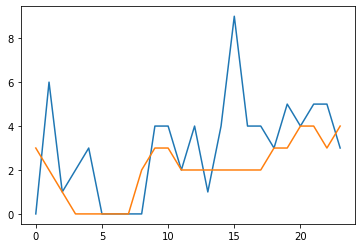

RMSE :  2.23606797749979


In [68]:
"""
Full Training Routine 
with hyperparmeter grid search

Load data into TimeSeriesDataSet object

for fast development run
uncomment fast_dev_run = fdv_steps

"""

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

for neu,lay,bat,lr,enc_len,pred_len,drop,num_ep in product(*[x for x in hparams_grid.values()]):

    ######### Load DATA #############
    train_dataset = TimeSeriesDataSet(
        df.iloc[0:tr_stop_idx],
        time_idx="time_idx",
        target=Target,
        categorical_encoders={cat_col1: NaNLabelEncoder(add_nan=True).fit(df[cat_col1]), cat_col2:NaNLabelEncoder(add_nan=True).fit(df[cat_col2]),cat_col3:NaNLabelEncoder(add_nan=True).fit(df[cat_col3]), \
            cat_col4:NaNLabelEncoder(add_nan=True).fit(df[cat_col4]),"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)},
        group_ids=["group"],
        min_encoder_length=enc_len,
        max_encoder_length=enc_len,
        min_prediction_length=pred_len,
        max_prediction_length=pred_len,
        time_varying_unknown_reals=[Target],
        time_varying_known_reals=num_cols_list,
        time_varying_known_categoricals=[cat_col1,cat_col2,cat_col3,cat_col4,"_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"],
        add_relative_time_idx=False,
        randomize_length=False,
        scalers={},
        target_normalizer=TorchNormalizer(method="identity",center=False,transformation=None )

    )

    val_dataset = TimeSeriesDataSet.from_dataset(train_dataset,df.iloc[tr_stop_idx:val_stop_idx], stop_randomization=True)
    test_dataset = TimeSeriesDataSet.from_dataset(train_dataset,df.iloc[val_stop_idx:tes_stop_idx], stop_randomization=True)

    train_dataloader = train_dataset.to_dataloader(train=True, batch_size=bat)
    val_dataloader = val_dataset.to_dataloader(train=False, batch_size=bat)
    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=bat)
    ######### Load DATA #############


    """
    Baseline predictions START
    1) Persistance model (last value)

    2) Persistance model ( seasonal naive forecast )
    """
    # ############## 1) Persistance model (last value) #######################
    # actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
    # baseline_predictions = Baseline().predict(test_dataloader)
    # print(f" Persistance model (last value), sMAPE : {SMAPE()(baseline_predictions, actuals)}")
    # print(f" Persistance model (last value), RMSE : {RMSE()(baseline_predictions,actuals)}")
    # r2score = R2Score()
    # print(f" Persistance model (last value), R2 Score : { np.mean([ r2score(baseline_predictions[i], actuals[i])    for i in range(len(actuals)) ]) }" )
    # ############## 1) Persistance model (last value) #######################


    # ############## 2) Persistance model ( seasonal naive forecast ) #######################
    # predictions = np.array([])
    # actuals1 = df[Target][seas_pred_strt_idx:seas_pred_strt_idx+24]
    # for h in range(24):
    #     sum1 = 0
    #     for n in range(num_past_seas):
    #         sum1 = sum1 + df[Target][seas_pred_strt_idx+h - season_len*n]
        
    #     predictions = np.append(predictions,sum1/num_past_seas)

    # predictions = predictions.astype(int)
    # actuals1 = np.array(actuals1)

    # smape = SymmetricMeanAbsolutePercentageError()
    # mse = MeanSquaredError()
    # print(f"\nseasonal prediction start index:  {seas_pred_strt_idx}")
    # print(f" Persistance model ( seasonal naive forecast ) , sMAPE : { smape(  torch.Tensor(predictions),torch.Tensor(actuals1))    }")
    # print(f" Persistance model ( seasonal naive forecast ) , RMSE : {np.sqrt(mse(torch.Tensor(predictions),torch.Tensor(actuals1)))}")
    # r2score = R2Score()
    # print(f" Persistance model ( seasonal naive forecast ) , R2 Score : {r2score( torch.Tensor(predictions),torch.Tensor(actuals1)) }" )
    # plt.title("(average) seasonal naive forecast")
    # plt.plot(predictions,color='r')
    # plt.plot(actuals1,color='b')
    # plt.show()
    # ############## 2) Persistance model ( seasonal naive forecast ) #######################
    """
    Baseline predictions END
    """



    """
    Machine Learning predictions START
    1) DeepAR

    """
    trainer = pl.Trainer(
        max_epochs=num_ep,
        gpus=-1,
        auto_lr_find=True,
        gradient_clip_val=0.1,
        limit_train_batches=1.0,
        limit_val_batches=1.0,
        #fast_dev_run=fdv_steps,
        logger=True,
        #log_every_n_steps=10,
        # profiler=True,
        callbacks=[lr_logger, early_stop_callback],
        enable_checkpointing=True,
        #default_root_dir="C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\2_freq_nbinom_LSTM\1_cluster_demand_prediction\logs"
    )
    #print(f"training routing:\n \n {trainer}")
    deepar = DeepAR.from_dataset(
        train_dataset,
        #learning_rate=lr,
        hidden_size=neu,
        rnn_layers=lay,
        dropout=drop,
        loss=Loss,
        log_interval=10,
        log_val_interval=3,
        log_gradient_flow=True,
        # reduce_on_plateau_patience=3,
    )
    #print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")
    # print(f"Model :\n \n {deepar}")
    torch.set_num_threads(10)
    trainer.fit(
        deepar,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    ########## Prediction #####################

    test_output = deepar.predict(data=test_dataloader,mode='prediction',return_index=True,num_workers=8,show_progress_bar=True)

    plt.plot(df['clstr_175'].iloc[2038:2038+pred_len].values)
    pred = np.array(test_output[0][0]).astype(int)
    plt.plot(pred)
    plt.show()

    print('RMSE : ',np.sqrt(mean_squared_error(df['clstr_175'].iloc[2038:2038+pred_len].values,pred )))

    ########## Prediction #####################
    """
    Machine Learning predictions END
    """


In [69]:
"""
View tensorboard logs

"""



'\nView tensorboard logs\n\n'

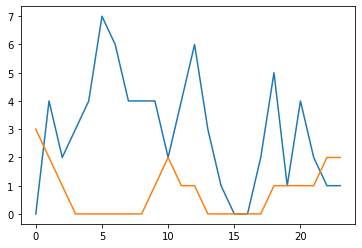

In [70]:
    plt.plot(df['clstr_175'].iloc[2076:2076+pred_len].values)
    pred = np.array(test_output[0][48]).astype(int)
    plt.plot(pred)
    plt.show()